In [3]:
# 📦 Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import shap
import umap.umap_ as umap

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")


In [4]:
# 📥 Load
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

# 🧠 Merge for unified preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)

# 👀 Preview
df.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [5]:
# 🚧 Drop non-feature columns (if any)
if 'subject' in df.columns:
    df.drop('subject', axis=1, inplace=True)

# 🎯 Target = Activity Label
target_col = 'Activity' if 'Activity' in df.columns else 'activity'
y = df[target_col]
X = df.drop(columns=[target_col])

# 🔢 Label encode activity
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 🧽 Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Ready to go
print("✅ Preprocessing complete")


✅ Preprocessing complete


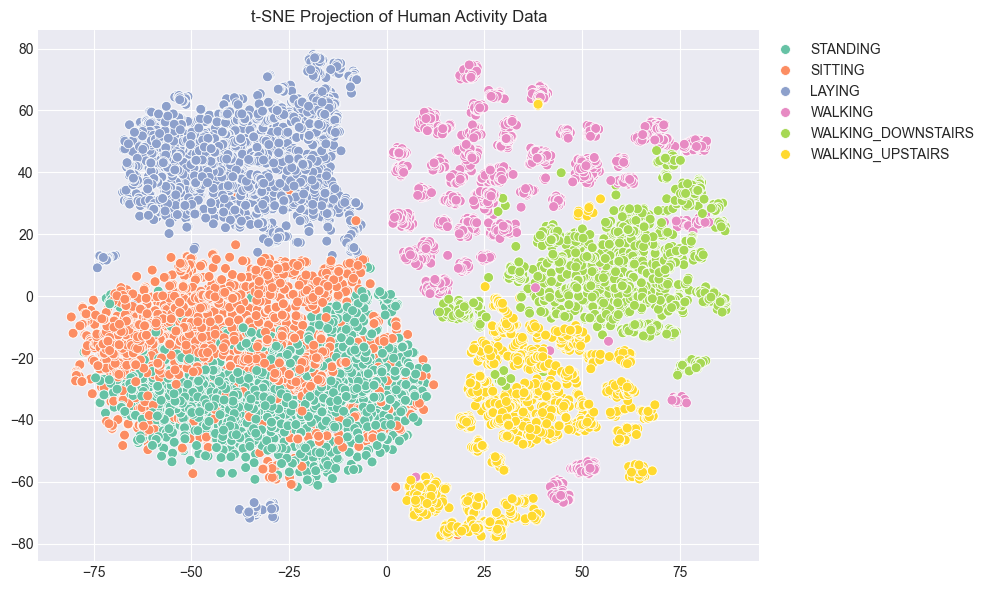

In [6]:
# ⏱️ Reduce to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 🎨 Plot t-SNE by activity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=le.inverse_transform(y_encoded), palette="Set2", s=50)
plt.title("t-SNE Projection of Human Activity Data")
plt.legend(loc="best", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("../outputs/tsne_projection.png")
plt.show()


In [7]:
# 🔍 Isolation Forest setup
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_preds = iso_forest.fit_predict(X_scaled)

# 🧾 Translate predictions: 1 = normal, -1 = anomaly
iso_preds_binary = np.where(iso_preds == 1, 0, 1)

# 📊 Frequency of predicted anomalies
unique, counts = np.unique(iso_preds_binary, return_counts=True)
print(dict(zip(["Normal", "Anomaly"], counts)))


{'Normal': np.int64(9784), 'Anomaly': np.int64(515)}


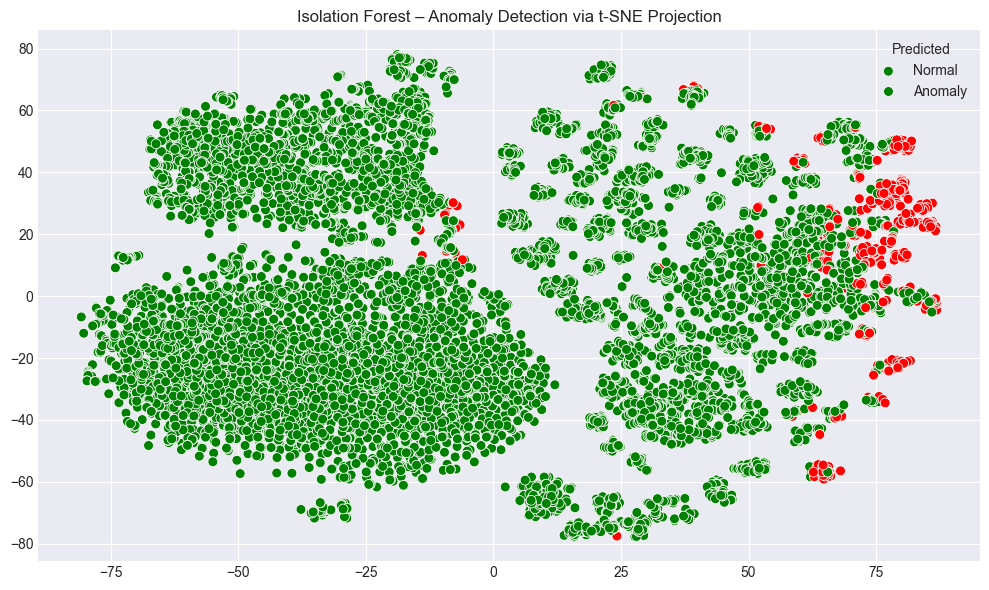

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=iso_preds_binary, palette=["green", "red"], s=50)
plt.title("Isolation Forest – Anomaly Detection via t-SNE Projection")
plt.legend(title="Predicted", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.savefig("../outputs/isolation_forest_tsne.png")
plt.show()


In [9]:
# 💡 This only works if you want to treat one class as anomalous
# Let's assume "LAYING" is the rarest and we treat it as anomaly (example)
df['Activity'] = y
activity_counts = df['Activity'].value_counts()
print(activity_counts)

# Find rarest activity to treat as anomaly
rarest_activity = activity_counts.idxmin()
anomaly_true = (df['Activity'] == rarest_activity).astype(int)

print(f"Treated activity '{rarest_activity}' as anomaly for evaluation")

# 🎯 ROC AUC
roc_score = roc_auc_score(anomaly_true, iso_preds_binary)
print(f"Isolation Forest ROC AUC: {roc_score:.3f}")


Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64
Treated activity 'WALKING_DOWNSTAIRS' as anomaly for evaluation
Isolation Forest ROC AUC: 0.601


In [10]:
# ⚙️ One-Class SVM setup
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_preds = oc_svm.fit_predict(X_scaled)

# 🔁 Convert: 1 = normal, -1 = anomaly
svm_preds_binary = np.where(svm_preds == 1, 0, 1)

# 📊 Prediction count
unique, counts = np.unique(svm_preds_binary, return_counts=True)
print(dict(zip(["Normal", "Anomaly"], counts)))


{'Normal': np.int64(9787), 'Anomaly': np.int64(512)}


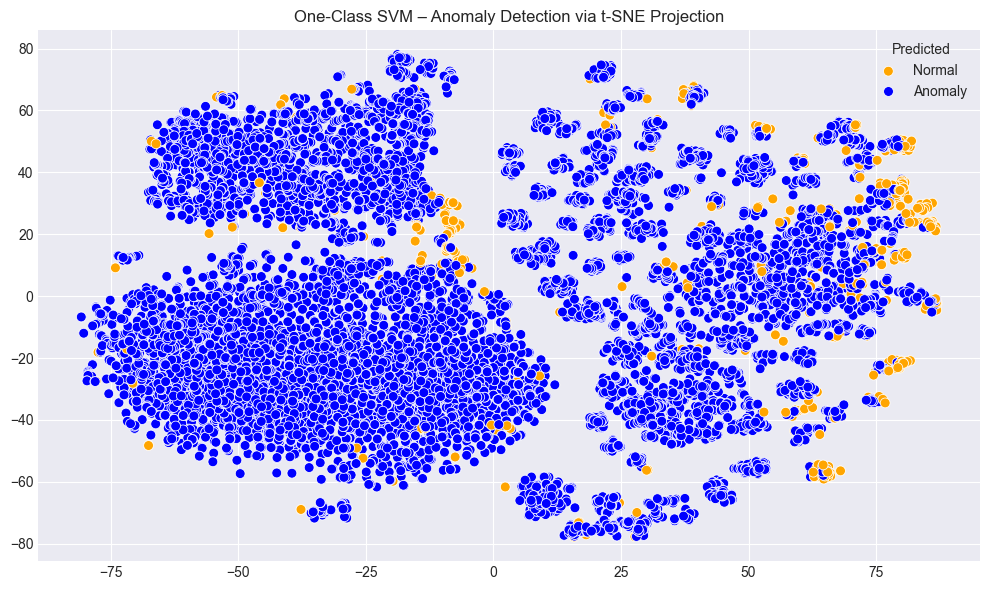

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=svm_preds_binary, palette=["blue", "orange"], s=50)
plt.title("One-Class SVM – Anomaly Detection via t-SNE Projection")
plt.legend(title="Predicted", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.savefig("../outputs/svm_tsne.png")
plt.show()


In [12]:
# Same rarest activity label used earlier
roc_svm = roc_auc_score(anomaly_true, svm_preds_binary)
print(f"One-Class SVM ROC AUC: {roc_svm:.3f}")


One-Class SVM ROC AUC: 0.553


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 🧠 Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="linear")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# 🏋️‍♀️ Train
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Epoch 1/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5198 - val_loss: 0.3160
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.3327 - val_loss: 0.2699
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.2879 - val_loss: 0.2453
Epoch 4/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.2613 - val_loss: 0.2276
Epoch 5/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.2448 - val_loss: 0.2156
Epoch 6/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.2341 - val_loss: 0.2079
Epoch 7/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.2268 - val_loss: 0.2046
Epoch 8/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.2223 - val_loss: 0.2001
Epoch 9/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.2188 - val_loss: 0.2018
Epoch 10/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.2164 - val_loss: 0.1976
Epoch 11/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.2143 - val_loss: 0.1962
Epoch 12/30
145/145 ━━━━━━━━━━━━

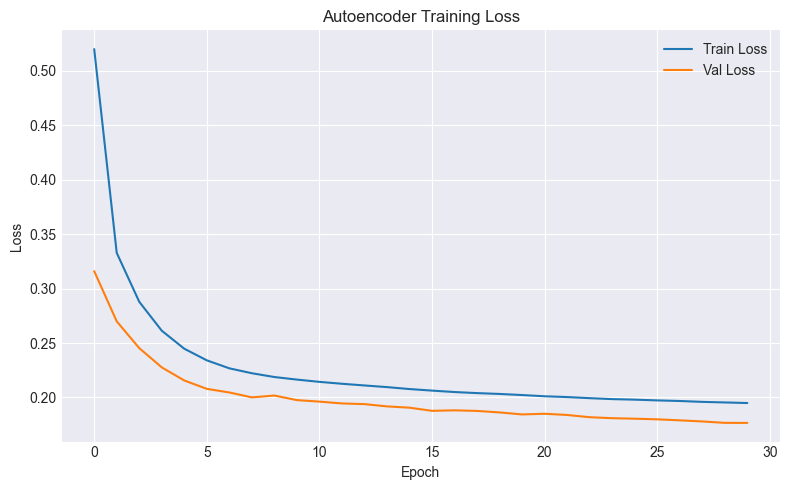

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/autoencoder_loss.png")
plt.show()


In [15]:
# 🔎 Predict and get reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# 🧾 Set threshold: 95th percentile
threshold = np.percentile(mse, 95)
autoencoder_preds_binary = (mse > threshold).astype(int)

print(f"Anomalies above threshold {threshold:.4f}: {autoencoder_preds_binary.sum()} out of {len(mse)}")


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
Anomalies above threshold 0.4077: 515 out of 10299


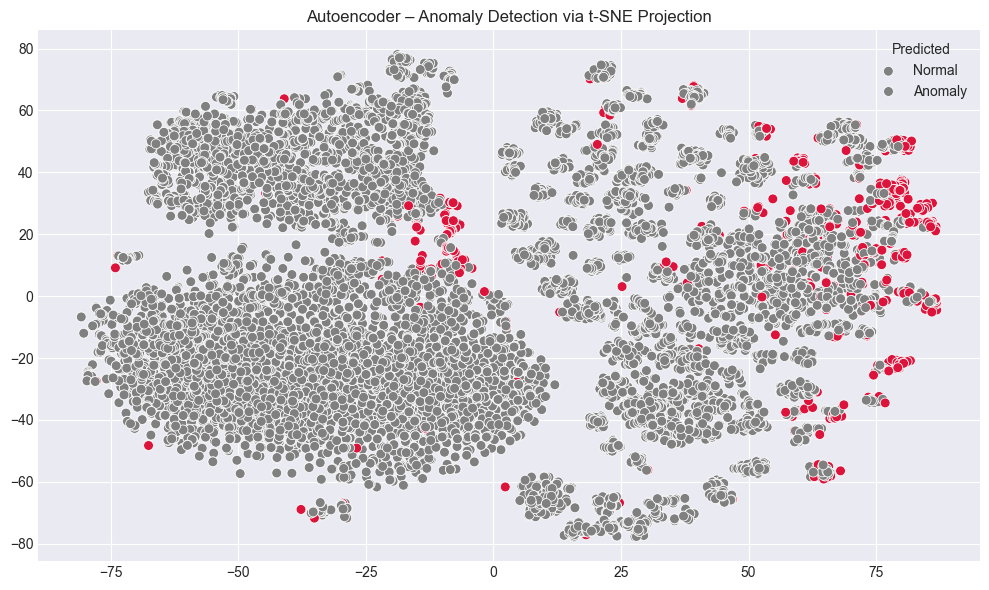

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=autoencoder_preds_binary, palette=["gray", "crimson"], s=50)
plt.title("Autoencoder – Anomaly Detection via t-SNE Projection")
plt.legend(title="Predicted", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.savefig("../outputs/autoencoder_tsne.png")
plt.show()


In [17]:
roc_auto = roc_auc_score(anomaly_true, autoencoder_preds_binary)
print(f"Autoencoder ROC AUC: {roc_auto:.3f}")


Autoencoder ROC AUC: 0.578


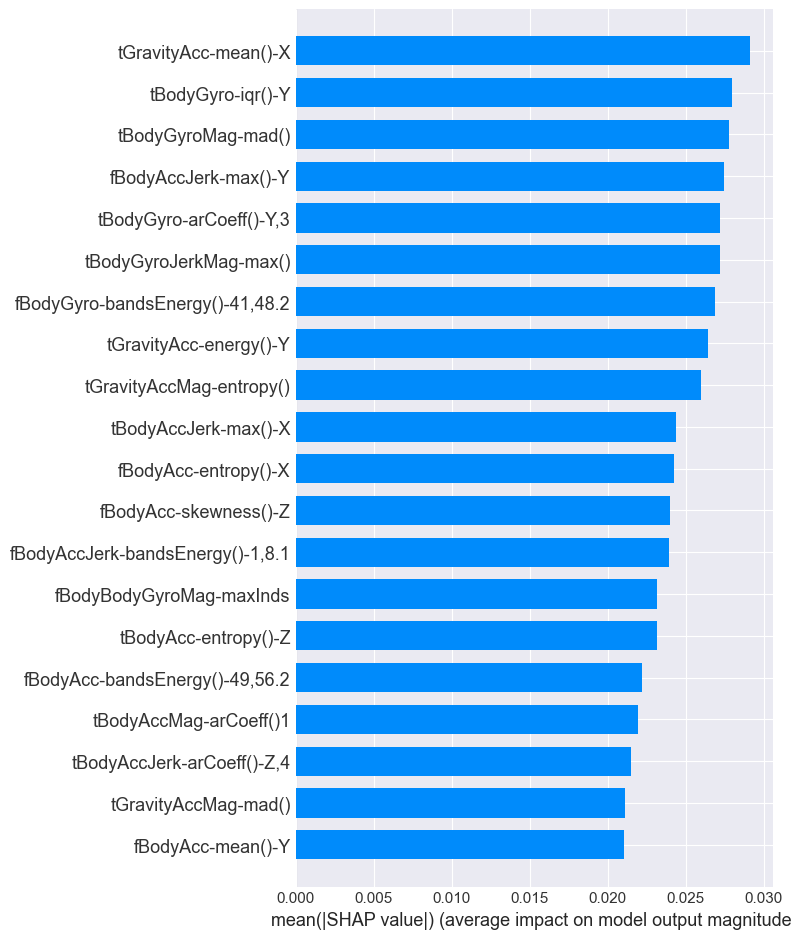

In [18]:
# ⚙️ Use TreeExplainer for Isolation Forest
explainer = shap.Explainer(iso_forest)
shap_values = explainer(X_scaled)

# 💡 Show feature importance summary
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns.tolist(), plot_type="bar")


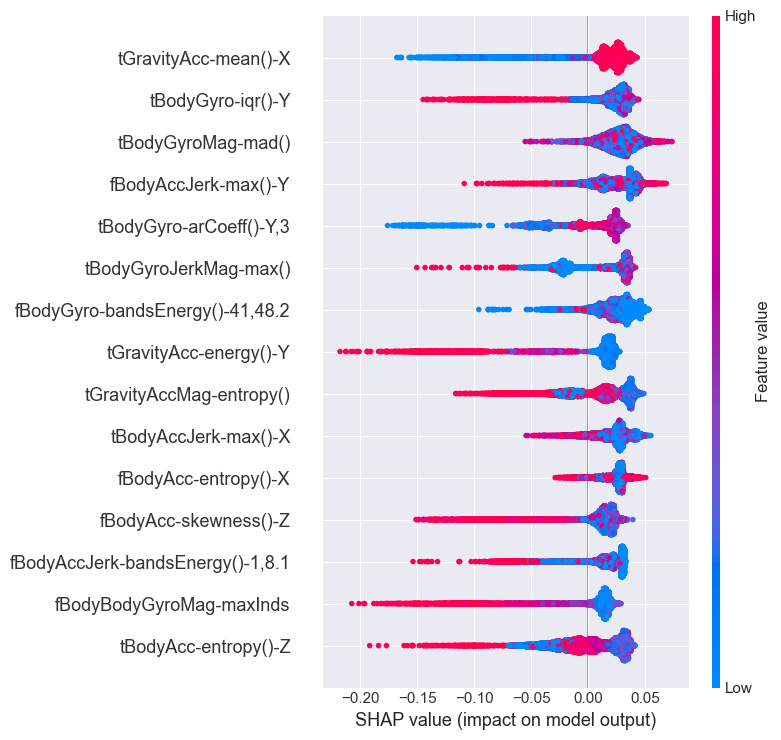

In [19]:
# 🐝 Beeswarm plot for top 15 features
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns.tolist(), max_display=15)


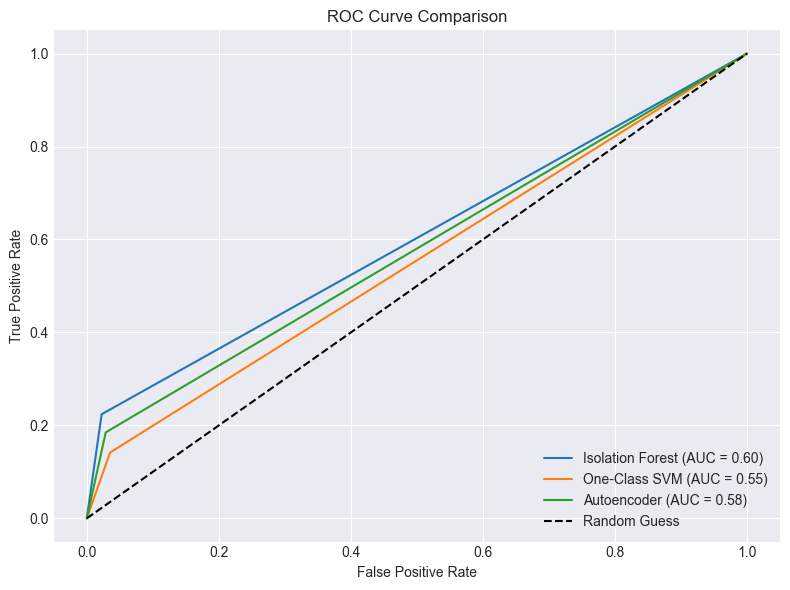

In [20]:
# 🔍 Compute FPR, TPR for each model
fpr_iso, tpr_iso, _ = roc_curve(anomaly_true, iso_preds_binary)
fpr_svm, tpr_svm, _ = roc_curve(anomaly_true, svm_preds_binary)
fpr_ae, tpr_ae, _ = roc_curve(anomaly_true, autoencoder_preds_binary)

# 📈 Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, label=f"Isolation Forest (AUC = {roc_score:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"One-Class SVM (AUC = {roc_svm:.2f})")
plt.plot(fpr_ae, tpr_ae, label=f"Autoencoder (AUC = {roc_auto:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/roc_curve.png")
plt.show()


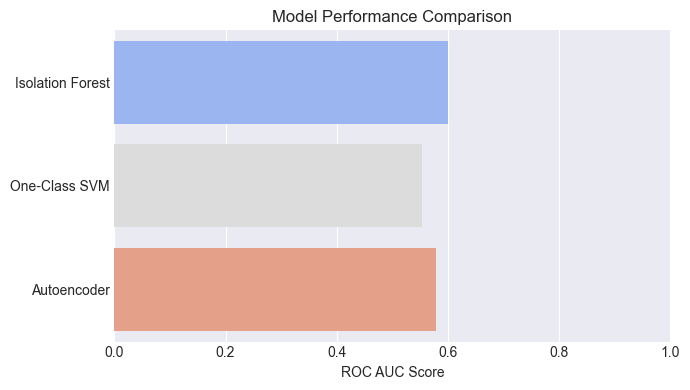

In [21]:
# 📊 AUC bar plot
model_names = ["Isolation Forest", "One-Class SVM", "Autoencoder"]
auc_scores = [roc_score, roc_svm, roc_auto]

plt.figure(figsize=(7, 4))
sns.barplot(x=auc_scores, y=model_names, palette="coolwarm")
plt.xlabel("ROC AUC Score")
plt.title("Model Performance Comparison")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("../outputs/model_comparison.png")
plt.show()


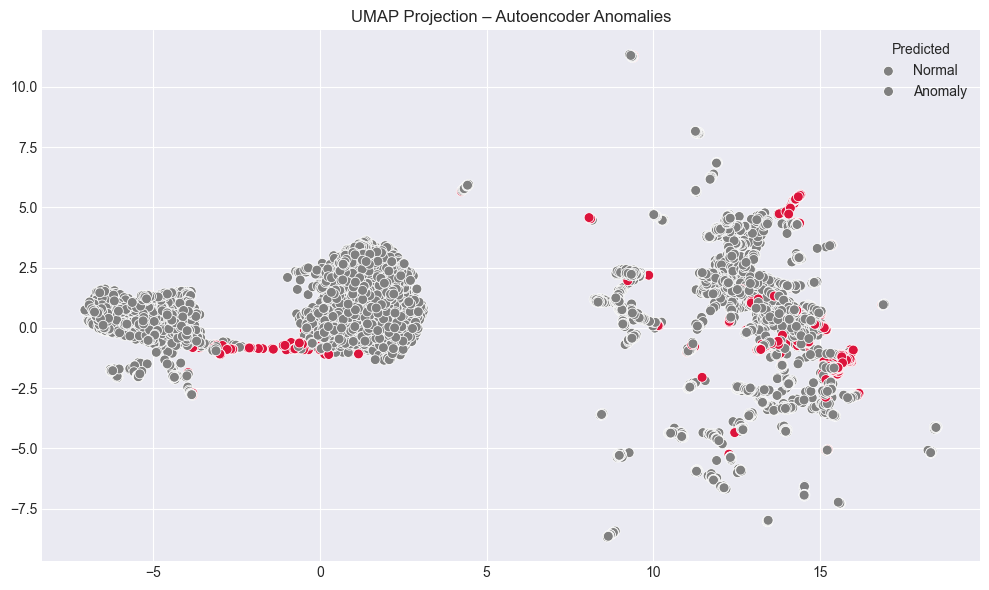

In [22]:
# 🌀 UMAP 2D projection
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=autoencoder_preds_binary, palette=["gray", "crimson"], s=50)
plt.title("UMAP Projection – Autoencoder Anomalies")
plt.legend(title="Predicted", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.savefig("../outputs/umap_autoencoder.png")
plt.show()
